In [4]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )
    
    
    ! pip install geopandas

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

# modify path
fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)    
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

# compile cython routing script
COMPILE_cython = True
# ! This will definitely work in the Google Colab environment, though may not work
# in your local envioronment.
if COMPILE_cython:

    subprocess.run(
        ["gfortran", "varPrecision.f90", "-c", "-o", "var_precision.o", "-O3", "-fPIC"],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "MCsingleSegStime_f2py_NOLOOP.f90",
            "-c",
            "-o",
            "mc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )

    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])

    if ENV_IS_CL:
        numpy_I = "/usr/local/lib/python3.6/dist-packages/numpy/core/include"
        py_I = "/usr/include/python3.6"
        py_lib = "/usr/include/python3.6"

    else:
        bin_exe = pathlib.Path(sys.executable)
        virtual_env_path = bin_exe.parents[1]
        py_lib = os.path.join(virtual_env_path, "lib")
        numpy_I = os.path.join(
            py_lib, "python3.6", "dist-packages", "numpy", "core", "include"
        )
        py_I = os.path.join(virtual_env_path, "include", "python3.6m")

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "mc_reach.pyx",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-Wno-unused-result",
            "-Wsign-compare",
            "-DNDEBUG",
            "-g",
            "-fwrapv",
            "-O3",
            "-fno-strict-aliasing",
            "-Wall",
            "-Wstrict-prototypes",
            "-fPIC",
            "-I",
            numpy_I,
            "-I",
            py_I,
            "-c",
            "mc_reach.c",
            "-o",
            "mc_reach.o",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared",
            "-L",
            py_lib,
            "var_precision.o",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "mc_reach.o",
            "-lgfortran",
            "-o",
            "mc_reach.cpython-36m-x86_64-linux-gnu.so",
        ],
        cwd=routing_v02_dir,
    )

# load needed scientific libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import chain
from functools import partial

# turn off warnings
import warnings
warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import mc_reach


/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/mc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/pymc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/var_precision.o


In [5]:
def sim(dx, dt, q_baseflow, q_pk, short_tstep_assumption):

    ################################################
    # Set-up model domain
    ################################################
    # SPACE
    L = 20 * (1000) # meters
    nsegs = round(L/dx)

    # TIME
    n_days = 6
    len_sim = n_days*(24*60*60) # seconds
    nts = round(len_sim/dt)


    ################################################
    # Create model parameter set
    ################################################
    link_start = 8815967 # arbitrary linkID for the top segment of the reach
    headwaters = [8815960, 8815961] # create two headwaters, one of which will accept lateral inflows

    # construct linkIDs and destination linkIDs
    linkID = list(range(link_start,
                        link_start + nsegs,
                        1))
    linkID = headwaters + linkID

    headwater_to = [link_start, link_start]
    toID = list(range(link_start + 1,
                      link_start + nsegs,
                      1))
    toID.append(0)
    toID = headwater_to + toID

    # link-distance lookup - what is the physical distance associated with each segment? 
    link_distance = {}
    for i, link in enumerate(linkID[2:],1):
        link_distance[i*dx] = link

    # build parameter DataFrame
    d = {'link': linkID,
          'to': toID,
          'dx': [dx] * (nsegs+2),
          'n': [0.028] * (nsegs+2),
          'ncc': [0.031] * (nsegs+2),
          's0': [0.0018] * (nsegs+2),
          'bw': [112] * (nsegs+2),
          'tw': [448] * (nsegs+2),
          'twcc': [623] * (nsegs+2),
          'MusK': [3600.0] * (nsegs+2),
          'MusX': [0.2] * (nsegs+2),
          'cs': [1.40] * (nsegs+2)}

    df = pd.DataFrame(data=d)
    df = df.set_index('link')
    df = df.sort_index()

    # replace downstreams for terminal segments
    df = nhd_io.replace_downstreams(df, 'to', 0)

    ################################################
    # Create lateral inflow data
    ################################################
    t_pk = 2*24*(60*60)
    width = 2*(60*60)


    x = np.linspace(0,len_sim, round(len_sim/dt))
    y = norm.pdf(x,t_pk,width)
    y_scale = y * q_pk/max(y) + q_baseflow

    # construct lateral inflow series
    ql = pd.DataFrame(0, index=linkID, columns=range(round(len_sim/dt)),dtype=np.float32)
    ql.iloc[0,:] = y_scale

    ################################################
    # Build network
    ################################################
    conn = nhd_network.extract_connections(df, 'to')
    rconn = nhd_network.reverse_network(conn)
    subnets = nhd_network.reachable_network(rconn, check_disjoint = False)

    # identify the segments in each subnetwork
    subreachable = nhd_network.reachable(rconn)

    # break each subnetwork into reaches
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

    tail_water = max(linkID)
    reach = subreaches[tail_water]
    r = list(filter(None, chain.from_iterable(reach)))

    ################################################
    # Simulate network routing
    ################################################
    # add a dt column to the data DataFrame
    df["dt"] = dt

    # change variables to type float32, as expected by mc_reach.compute_network
    df = df.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = df.loc[
        r, ["dt", "dx", "bw", "tw", "twcc", "n", "ncc", "cs", "s0"]
    ].sort_index()

    # create qlat dataset
    qlat_sub = ql.loc[r].sort_index()

    # compute the network routing, calculate (flow, depth, and velocity)
    results = []

    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values.astype("float32"),
            assume_short_ts=short_tstep_assumption
        )
    )

    ################################################
    # re-format simulation output
    ################################################

    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()


    # create flow DataFrame
    flows = flowveldepth.loc[:, (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    flows['Time (d)'] = ((flows.Timestep + 1) * dt)/(24*60*60)
    flows = flows.set_index('Time (d)')
    flows = flows.drop(["Timestep", "Parameter"], axis=1)
    
    forcing = flows.loc[:,flows.columns.min()]
    
    flows = flows.drop(headwaters, axis = 'columns')

    # create depth DataFrame
    depth = flowveldepth.loc[:, (slice(None), "d")]
    depth = depth.T.reset_index(level = [0,1])
    depth.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    depth['Time (d)'] = ((depth.Timestep + 1) * dt)/(24*60*60)
    depth = depth.set_index('Time (d)')
    depth = depth.drop(["Timestep", "Parameter"], axis=1)
    depth = depth.drop(headwaters, axis = 'columns')
    
    return flows, depth, df, forcing


In [6]:
def courant(depth, df, dt, dx):
    
    # channel side distance
    z = 1.0/df.loc[depth.columns].cs

    # bankfull depth (assumes tw > bw)
    bfd =  (df.loc[depth.columns].tw - df.loc[depth.columns].bw)/(2*z)

    Ck = pd.DataFrame(0, index=depth.index, columns=depth.columns,dtype=np.float32)
    for idx_s, s in enumerate(depth.columns,0):

        d_numpy = depth.loc[:,s].to_numpy()
        t_gt_bf = np.nonzero(d_numpy > bfd[s])
        t_lt_bf = np.nonzero(d_numpy < bfd[s])


        idx_gt_bf = depth.iloc[t_gt_bf[0],idx_s].index
        idx_lt_bf = depth.iloc[t_lt_bf[0],idx_s].index

        # ******* when depth is above bank full *******
        h = depth.loc[idx_gt_bf,s]

        AREA =  (df.loc[s].bw + bfd * z[s]) * bfd
        AREAC = (df.loc[s].twcc * (h - bfd)) 
        WP = (df.loc[s].bw + 2 * bfd * np.sqrt(1 + z[s]*z[s]))
        WPC = df.loc[s].twcc + (2 * (h - bfd))
        R   = (AREA + AREAC)/(WP + WPC)

        ck =  ((np.sqrt(df.loc[s].s0)/df.loc[s].n)*((5/3)*R**(2/3) - \
                    ((2/3)*R**(5/3)*(2*np.sqrt(1 + z[s]*z[s])/(df.loc[s].bw+2*bfd*z[s]))))*AREA \
                    + ((np.sqrt(df.loc[s].s0)/(df.loc[s].ncc))*(5/3)*(h - bfd)**(2/3))*AREAC)/(AREA+AREAC)

        Ck.loc[idx_gt_bf,s] = ck

        # ******* when depth is below bank full ********
        AREA = (df.loc[s].bw + depth.loc[idx_lt_bf,s] * z[s] ) * depth.loc[idx_lt_bf,s]
        WP = (df.loc[s].bw + 2 * depth.loc[idx_lt_bf,s] * np.sqrt(1 + z[s]*z[s]))
        R = AREA / WP

        ck = (np.sqrt(df.loc[s].s0)/df.loc[s].n)* \
                        ((5/3)*R**(2/3)-((2/3)*R**(5/3)* \
                         (2*np.sqrt(1 + z[s]*z[s])/(df.loc[s].bw+2*depth.loc[idx_lt_bf,s]*z[s]))))

        Ck.loc[idx_lt_bf,s] = ck

    # Courant number
    C = Ck * (dt/dx)
    
    return C



Simulation 0  - Timestep: 5 Spatial step: 300
courant number at peakflow =  0.57908034
maximum depth =  161.86197
------------------------------------------------------
Simulation 1  - Timestep: 10 Spatial step: 300
courant number at peakflow =  0.09609824
maximum depth =  1.2637823
------------------------------------------------------
Simulation 2  - Timestep: 30 Spatial step: 300
courant number at peakflow =  0.28829488
maximum depth =  1.2637833
------------------------------------------------------
Simulation 3  - Timestep: 60 Spatial step: 300
courant number at peakflow =  6.9798503
maximum depth =  451.22644
------------------------------------------------------
Simulation 4  - Timestep: 120 Spatial step: 300
courant number at peakflow =  12.288318
maximum depth =  443.38892
------------------------------------------------------
Simulation 5  - Timestep: 400 Spatial step: 300
courant number at peakflow =  3.8034992
maximum depth =  1.2431936
-------------------------------------

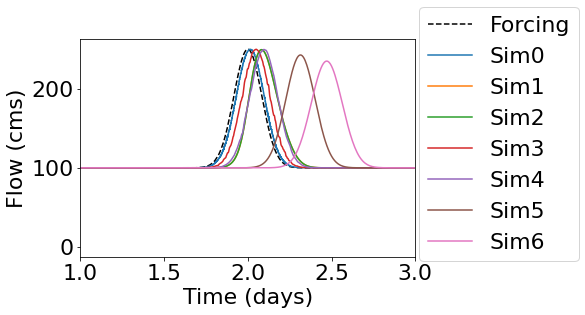

In [12]:
dx = 300
q_baseflow = 100 # cms
q_pk = 150 # cms
# dt_array = [1, 5, 10, 30, 60, 600, 1800, 3600, 3600*2]
dt_array = [5, 10, 30, 60, 120, 400, 600]

assume_short_timestep = False
            
for i, dt in enumerate(dt_array,0):
    
    # calculate flow and depth with MC model
    flow, depth, df, forcing = sim(dx, dt, q_baseflow, q_pk, assume_short_timestep)
    
    # calculate courant number, baseflow
    C = courant(depth, df, dt, dx)
    
    # baseflow courant number
    courant_peak = C[C.index > 1.5].loc[:,C.columns.max()].max()
    
    # peak flow
    qpk = flow.loc[:,flow.columns.max()].max()
    
    # max depth
    dmx = depth.loc[:,flow.columns.max()].max()
    
    # time of peak
    tpk = flow.loc[:,flow.columns.max()].idxmax()
    
    print("Simulation",i," - Timestep:",dt,"Spatial step:",dx)
    print("courant number at peakflow = ",courant_peak)
    print("maximum depth = ",dmx)
    print("------------------------------------------------------")
     
    time = flow.index.values
    q = flow.loc[:,flow.columns.max()]
    if i == 0:
        plt.plot(time, forcing, '--',color = 'k',label = "Forcing")
    
    plt.plot(time,q, label = "Sim" + str(i))
    
    

plt.xlim([1,3])
plt.ylabel("Flow (cms)")
plt.xlabel("Time (days)")
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.2), fancybox=True, shadow=False)
plt.rcParams.update({'font.size': 22})
fig = plt.gcf()
plt.show()
fig.savefig("../doc/wave_dt_sensitivity.png", bbox_inches='tight')

- The cell above can illustrate the implications of the short timestep assumption. 
- When dx = 1000 m, the assumption makes no difference for any timestep
- If we turn the dx down to dx = 500 m, the short timestep assumption produces wonky results for Sim 3, dt = 30 sec
- Meanwhile, the simulations are as expected at dx = 500 m when the short timestep assumption is turned off. 
- At an even smaller spatial step, dx = 100 m:
    - short timestep OFF: spurious depth oscillations when dt = 10 sec
    - short timestep ON: spurrious depth oscillations when dt = 10 sec, dt = 30, dt = 60
- Wonky behavior manifests in simulated depth. 
- I remain confused about the behavior of this model. 
- *** problems may be related to starting at zero flow ***